In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


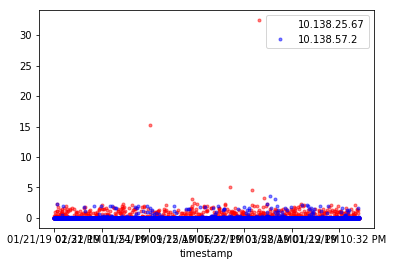

0.026701


In [2]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    client_data['timestamp'] = pd.DatetimeIndex(client_data['timestamp']).map(lambda x: x.replace(second=0, microsecond=0))

    data[client] = client_data


In [2]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_99th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
    p90 = df['latency'].quantile(0.99)    
    return df.query('latency<'+str(p90))['latency'].mean()

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        c['sender'] = d
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            gateway_table = pd.concat([gateway_table , c])
    return gateway_table
    
import numpy as np
import math
def cosine_similarity(a,b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))
    
        
        

In [3]:
def calculate_trust_score(trust_score, gateway_table, noce):
    gateways = gateway_table.query('sender == "'+node+'"')
    rest = gateway_table.query('sender != "'+node+'"')
    rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    for index, row in rest.iterrows():
        gw = gateways.query('gateway == "'+row['gateway']+'"')
        value = abs(gw['latency'].values[0] - row['latency'])

        if row['sender'] in trust_score:
            trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
        else:
            trust_score[row['sender']] = value
    
    return trust_score

def calculate_trust_score_transitive(trust_score, gateway_table, node, topk):
    if len(trust_score)< topk:
        topk = len(trust_score)
    trust_score = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:topk])
    #print(trust_score)
    trusted = []
    trusted.extend(list(trust_score.keys()))
    if node not in trust_score:
        trusted.append(node)
        
    trusted_gw = gateway_table[gateway_table.sender.isin(trusted)]    
    gateways= trusted_gw['gateway'].unique()    
    
    mean_gateways = trusted_gw.groupby('gateway').mean()
    
    rest = gateway_table[~gateway_table.sender.isin(trusted)]
    rest = rest[rest.gateway.isin(gateways)]
    trusted_gw = trusted_gw.append(rest)
    
    for name, group in trusted_gw.groupby('sender'):
        if name == node:
            continue
        score = 0
        cnt = 0
        for index, row in group.iterrows():
            gw_value = mean_gateways.query('gateway == "'+row['gateway']+'"')['latency'].values[0]
            
            score += abs(gw_value - row['latency'])
            cnt +=1
            
        v = score/cnt
        #print(name, v)
        if name in trust_score:
            trust_score[name] = 2/3*v + 1/3*trust_score[name]
        else:
            trust_score[name] = v
    #print(trust_score)
        #print(name)
        #print(type(group))
    #print(mean_gateways)
    #print(trusted_gw[['gateway','latency','sender']])
    
    
    
    #gateway_table[~gateway_table.sender.isin(trusted)]
    #rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    
    #print(gateways[['gateway', 'sender']])
    #print('=====================')
    #print(rest[['gateway', 'sender']])
    #print(rest[['gateway','sender']])
    #cnt = 0
    #for index, row in rest.iterrows():
    #    gw = gateways.query('gateway == "'+row['gateway']+'"')
    #    value = abs(gw['latency'].values[0] - row['latency'])

    #    if row['sender'] in trust_score:
    #        trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
    #        cnt+=1
    #    else:
    #        trust_score[row['sender']] = value
    #        cnt+=1
    
    #print(cnt)
    
    return trust_score
    

In [4]:

# Gateway table with all collaborators and MA
def build_gateway_table(gateway_table, new_df, ts):
    #print(new_df['gateway'].unique())
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)
    
#Gateway table with latest measurement without ma
def build_gateway_table1(gateway_table, new_df, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        size = len(group)
        mv_value = group['latency'].values[size-1]
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
            
            #print(name, mv_value, df_actual['latency'].values[0])
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

#Gateway table with MA and TOP K collaborators (absolute error)
def build_gateway_table2(gateway_table, new_df, trust_score, ts):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:5])
    print(trusted_col)
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [5]:
# Gateway table with all collaborators without MA
def build_gateway_table_no_ma(gateway_table, new_df,trust_score, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

# Gateway table with TOP K collaborators without MA
def build_gateway_table_no_ma_topk(gateway_table, new_df,trust_score, ts, k):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:k])
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

def build_gateway_table_ma_topk_error(gateway_table, new_df, trust_score, faulty_nodes):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:4])
    
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [88]:
#print(data['c2_2'][['gateway','latency']]) 
#data['c2_2']['latency'] = data['c2_2']['latency']*10 
#data['c5_1']['latency'] = data['c5_1']['latency']*10 
#data['c1_2']['latency'] = data['c1_2']['latency']*10 

In [229]:
print(data['c2_2']['latency'])

timestamp
2019-01-21 14:35:00    0.257984
2019-01-21 14:36:00    0.178664
2019-01-21 14:37:00    0.182187
2019-01-21 14:38:00    0.179872
2019-01-21 14:39:00    0.186970
2019-01-21 14:40:00    0.176158
2019-01-21 14:41:00    1.848960
2019-01-21 14:42:00    1.837210
2019-01-21 14:43:00    1.793280
2019-01-21 14:44:00    1.852150
2019-01-21 14:45:00    1.796980
2019-01-21 14:46:00    0.179601
2019-01-21 14:47:00    0.180826
2019-01-21 14:48:00    0.181106
2019-01-21 14:49:00    0.180974
2019-01-21 14:50:00    0.185573
2019-01-21 14:51:00    1.807050
2019-01-21 14:52:00    1.822670
2019-01-21 14:53:00    1.850200
2019-01-21 14:54:00    1.797400
2019-01-21 14:55:00    1.785800
2019-01-21 14:56:00    0.190883
2019-01-21 14:57:00    0.185969
2019-01-21 14:58:00    0.190768
2019-01-21 14:59:00    0.194400
2019-01-21 15:00:00    0.187567
2019-01-21 15:01:00    1.890330
2019-01-21 15:02:00    1.835280
2019-01-21 15:03:00    1.869350
2019-01-21 15:04:00    1.803430
                         ...  

In [ ]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date
end_date = start+datetime.timedelta(minutes = 1440)

#end_date = start+datetime.timedelta(minutes = 100)
history_gateway_table = pd.DataFrame()
gateway_table = {}
trust_score = {}
trust_score_transitive = {}
clients = {}
gw_table_similarity_ma = pd.DataFrame()
gw_table_similarity = pd.DataFrame()
gw_table_similarity_ma_top = pd.DataFrame()

gw_table_similarity_no_ma = pd.DataFrame()
gw_table_similarity_no_ma_top4 = pd.DataFrame()
gw_table_similarity_no_ma_top5 = pd.DataFrame()
gw_table_similarity_no_ma_top6 = pd.DataFrame()
gw_table_similarity_no_ma_top7 = pd.DataFrame()
#f = open('similarity_abs.csv','w')
while(start < end_date):
    rt = send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    gws = rt.query('sender=="c0_1"')['gateway'].values
    
    for index, row in rt.iterrows():
        if row["gateway"] in gws:
            if row['sender'] == "c0_1":
                continue
            if row["sender"] not in clients:
                clients[row["sender"]] = 1
            else:
                clients[row["sender"]] += 1
    
    #print(rt[['gateway','latency','sender']])
    
    
    history_gateway_table = pd.concat([history_gateway_table, rt])
    no_gws = len(history_gateway_table['gateway'].unique())
    #no_senders = len(history_gat)
    #trust_score = calculate_trust_score(trust_score, rt, 'c0_1')
    trust_score_transitive = calculate_trust_score_transitive(trust_score_transitive, rt, 'c0_1', 5)
    #print(rt.query('sender=="c2_2"')['latency'])
    print(sorted(trust_score_transitive.values()))
    
    #print(len(trust_score_transitive))
    
    #gw_table_similarity_no_ma = gw_table_similarity_no_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                             ignore_index=True)
    #gw_table_similarity_no_ma_top4 = gw_table_similarity_no_ma_top4.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma_topk(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"), 4)}, 
    #                                                             ignore_index=True)
    
    #gw_table_similarity_ma = gw_table_similarity_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                       'similarity':build_gateway_table(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                      ignore_index=True) 
    #gw_table_similarity = gw_table_similarity.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                  'similarity':build_gateway_table1(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, ignore_index=True)
    
    gw_table_similarity_ma_top = gw_table_similarity_ma_top.append({
        'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
        'similarity':build_gateway_table2(gateway_table, rt, trust_score_transitive, start.strftime("%m/%d/%Y, %H:%M:%S"))
    },  ignore_index=True)
    start = start+datetime.timedelta(minutes=2)
gw_table_similarity_ma_top.to_csv('similarity_error_5%_gradual.csv')
#gw_table_similarity_ma.to_csv("similarity_abs_ma.csv")
#gw_table_similarity.to_csv("similarity_error_15%.csv")
#gw_table_similarity.to_csv("similarity.csv")
#print(gw_table_similarity)
    


C:\Users\Khulan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0.0002830000000000332, 0.025023000000000017]
{'c0_2': 0.0002830000000000332, 'c0_3': 0.025023000000000017}
[0.0007333999999999986, 0.0017619999999999997, 0.004807333333333347, 0.010676000000000003, 0.045181]
{'c1_1': 0.0007333999999999986, 'c1_2': 0.0017619999999999997, 'c0_2': 0.004807333333333347, 'c0_3': 0.010676000000000003, 'c1_3': 0.045181}
[0.0008225866666666721, 0.0028520000000000004, 0.0038388333333333334, 0.005864820000000007, 0.006674333333333329, 0.007863111111111116, 0.008186750000000003, 0.016337120000000004, 0.01914425, 0.024263000000000007, 0.03604763999999999, 0.039312, 0.04042875, 0.044777319999999995, 0.07094924999999999, 0.17123256000000003, 0.21549306000000004, 0.25842106000000004]
{'c1_1': 0.0008225866666666721, 'c2_1': 0.0028520000000000004, 'c0_3': 0.0038388333333333334, 'c5_2': 0.005864820000000007, 'c1_2': 0.006674333333333329}
[0.0038206666666666667, 0.005130777777777774, 0.0076166200000000045, 0.008820500000000009, 0.013440999999999977, 0.0168905, 0.0173975

[0.0011339646913580237, 0.003034073333333337, 0.0037561073251028776, 0.007547906666666661, 0.012308854444444439, 0.017056500000000016, 0.021866451111111115, 0.022539339999999998, 0.027742339999999997, 0.030395906666666663, 0.03200084, 0.03630625, 0.04186600000000004, 0.054140680000000004, 0.09481425000000002, 0.504995]
{'c2_2': 0.0011339646913580237, 'c1_1': 0.003034073333333337, 'c2_1': 0.0037561073251028776, 'c3_1': 0.007547906666666661, 'c1_3': 0.012308854444444439}
[0.0015100857750342928, 0.0015706833333333358, 0.006834321563786007, 0.014341456666666667, 0.014945543333333332, 0.018060924999999995, 0.020337849999999998, 0.022455924999999998, 0.023102425000000006, 0.023932500000000002, 0.029597425000000004, 0.030414543333333335, 0.03632899999999999, 0.047748925, 0.053755043333333336, 0.18948149777777776, 0.1963954514814815, 0.34773675]
{'c2_1': 0.0015100857750342928, 'c1_1': 0.0015706833333333358, 'c2_2': 0.006834321563786007, 'c3_2': 0.014341456666666667, 'c5_3': 0.01494554333333333

In [57]:
print(get_99th_percentile())


0.15623515279615263


In [69]:
def getECDF(df):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df.similarity.value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

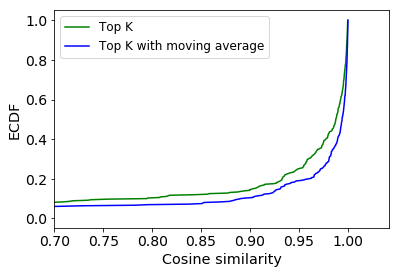

In [20]:
#gw_table_similarity_ma.set_index(pd.DatetimeIndex(gw_table_similarity_ma['timestamp']))
#gw_table_similarity.set_index(pd.DatetimeIndex(gw_table_similarity['timestamp']))
#gw_table_similarity_ma_top.set_index(pd.DatetimeIndex(gw_table_similarity_ma_top['timestamp']))

gw_table_similarity_no_ma.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma['timestamp']))
gw_table_similarity_no_ma_top4.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma_top4['timestamp']))

getECDF(gw_table_similarity_no_ma_top4).plot(color='green')
#getECDF(gw_table_similarity_no_ma_top5).plot(color='blue')
#getECDF(gw_table_similarity_no_ma_top6).plot(color='orange')
#getECDF(gw_table_similarity_no_ma_top7).plot(color='cyan')

#getECDF(gw_table_similarity).plot(color='red')
#getECDF(gw_table_similarity_no_ma).plot(color='red')

getECDF(gw_table_similarity_ma_top).plot(color='blue')

plt.legend(['Top K', 'Top K with moving average'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.xlim(0.7)

plt.tick_params(axis='both', which='major', labelsize=14)
#plot.tick_params(axis='both', which='minor', labelsize=8)


plt.show()

In [253]:
temp =  pd.read_csv(os.path.join('error_transitive_pattern_8clients.csv'), sep=',', index_col='timestamp')
temp.head()

,error 5%,error 10%,error 15%
timestamp,,,
"01/21/2019, 14:32:00",0.967222,0.997620,0.994969
"01/21/2019, 14:34:00",0.999411,0.942722,0.992565
"01/21/2019, 14:36:00",0.995073,0.998207,0.999553
"01/21/2019, 14:38:00",0.998500,0.998539,0.998575
"01/21/2019, 14:40:00",0.997737,0.996231,0.994152


In [254]:
def getECDF1(df, col):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[col].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

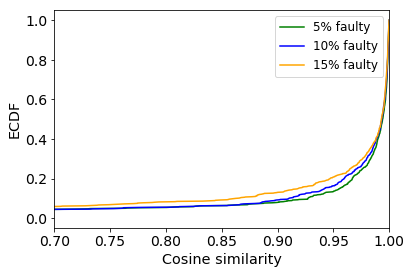

In [256]:
getECDF1(temp, 'error 5%').plot(color='green')
getECDF1(temp, 'error 10%').plot(color='blue')
getECDF1(temp, 'error 15%').plot(color='orange')
#getECDF1(temp, 'no error').plot(color='red')

plt.legend(['5% faulty', '10% faulty', '15% faulty', 'no error'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(0.7,1)
plt.show()

In [89]:
def change_error_pattern(clients):
    temp = data
    for client in clients:        
        df = temp[client]
        for index, grouped in df.groupby('gateway'):
            df_t = grouped.head(1440)
            cnt = 0
            for index1, row in df_t.iterrows():
                if cnt>5:
                    df.set_value(index.strftime("%m/%d/%Y %H:%M:%S"),'latency', row['latency']*10)
                if cnt == 10:
                    cnt =0
                cnt+=1
            
def change_error_gradual(clients):
    for client in clients:
        df_main = data[client]
        #df_main['latency'] = df_main.latency.fillna(0)
        last = None
        for name, grouped in df_main.groupby('gateway'):
            df = grouped.head(1440)
            start = 10
            s_ind = None
            end_ind = None
            for index1, row in df.iterrows():
                if s_ind == None:
                    s_ind = index1
                df.set_value(index1.strftime("%m/%d/%Y %H:%M:%S"),'latency',  (row['latency'] + (row['latency']*start)/100))
                df_main.loc[ (df_main['timestamp'] == index1.strftime("%m/%d/%Y %H:%M:%S")) & 
                                        (df_main['gateway']== name), 'latency'] = (row['latency'] + (row['latency']*start)/100)
                #print(temp)
                
                start += 1
                end_ind = index1
            
            
            #data[client] = data[client].reset_index()
            #df = df.reset_index()
            #update = pd.Series(df['latency'].values, name='latency', index=pd.date_range(s_ind, periods=200, freq='M'))
            
            print(df)
            #data[client].update(df)
            #data[client] = data[client].set_index('timestamp')
            
            
change_error_gradual(['c1_1'])


C:\Users\Khulan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Khulan\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                              timestamp      ttfb   latency        gateway  \
timestamp                                                                    
2019-01-21 14:34:00 2019-01-21 14:34:00  0.006565  0.021263  10.138.120.66   
2019-01-21 14:35:00 2019-01-21 14:35:00  0.007429  0.025154  10.138.120.66   
2019-01-21 14:36:00 2019-01-21 14:36:00  0.006715  0.021469  10.138.120.66   
2019-01-21 14:37:00 2019-01-21 14:37:00  0.006750  0.022216  10.138.120.66   
2019-01-21 14:38:00 2019-01-21 14:38:00  0.708803  0.827445  10.138.120.66   
2019-01-21 14:39:00 2019-01-21 14:39:00  0.006520  0.021775  10.138.120.66   
2019-01-21 14:40:00 2019-01-21 14:40:00  0.006550  0.022539  10.138.120.66   
2019-01-21 14:41:00 2019-01-21 14:41:00  0.006801  0.023704  10.138.120.66   
2019-01-21 14:42:00 2019-01-21 14:42:00  0.006527  0.027227  10.138.120.66   
2019-01-21 14:43:00 2019-01-21 14:43:00  0.006417  0.025521  10.138.120.66   
2019-01-21 14:44:00 2019-01-21 14:44:00  0.006542  0.027462  10.

                              timestamp      ttfb   latency      gateway  \
timestamp                                                                  
2019-01-21 14:34:00 2019-01-21 14:34:00  0.006444  0.022048  10.138.57.2   
2019-01-21 14:35:00 2019-01-21 14:35:00  0.007195  0.026935  10.138.57.2   
2019-01-21 14:36:00 2019-01-21 14:36:00  0.006420  0.023214  10.138.57.2   
2019-01-21 14:37:00 2019-01-21 14:37:00  0.006599  0.022508  10.138.57.2   
2019-01-21 14:38:00 2019-01-21 14:38:00  0.007082  0.024888  10.138.57.2   
2019-01-21 14:39:00 2019-01-21 14:39:00  0.007098  0.025056  10.138.57.2   
2019-01-21 14:40:00 2019-01-21 14:40:00  0.006812  0.023172  10.138.57.2   
2019-01-21 14:41:00 2019-01-21 14:41:00  0.007090  0.027543  10.138.57.2   
2019-01-21 14:42:00 2019-01-21 14:42:00  0.007548  0.026850  10.138.57.2   
2019-01-21 14:43:00 2019-01-21 14:43:00  0.006603  0.023889  10.138.57.2   
2019-01-21 14:44:00 2019-01-21 14:44:00  0.007720  0.035278  10.138.57.2   
2019-01-21 1

                              timestamp      ttfb   latency      gateway  \
timestamp                                                                  
2019-01-21 14:34:00 2019-01-21 14:34:00  0.019369  0.060953  10.139.17.4   
2019-01-21 14:35:00 2019-01-21 14:35:00  0.101193  0.163737  10.139.17.4   
2019-01-21 14:36:00 2019-01-21 14:36:00  0.014754  0.062994  10.139.17.4   
2019-01-21 14:37:00 2019-01-21 14:37:00  0.024229  0.058536  10.139.17.4   
2019-01-21 14:38:00 2019-01-21 14:38:00  0.015873  0.065376  10.139.17.4   
2019-01-21 14:39:00 2019-01-21 14:39:00  0.012578  0.057239  10.139.17.4   
2019-01-21 14:40:00 2019-01-21 14:40:00  0.012679  0.054049  10.139.17.4   
2019-01-21 14:41:00 2019-01-21 14:41:00  0.014697  0.095647  10.139.17.4   
2019-01-21 14:42:00 2019-01-21 14:42:00  0.013915  0.055703  10.139.17.4   
2019-01-21 14:43:00 2019-01-21 14:43:00  0.014497  0.071337  10.139.17.4   
2019-01-21 14:44:00 2019-01-21 14:44:00  0.014605  0.055933  10.139.17.4   
2019-01-21 1

                              timestamp      ttfb   latency        gateway  \
timestamp                                                                    
2019-01-21 14:34:00 2019-01-21 14:34:00  0.004351  0.007735  10.139.40.122   
2019-01-21 14:35:00 2019-01-21 14:35:00  0.005378  0.009193  10.139.40.122   
2019-01-21 14:36:00 2019-01-21 14:36:00  0.002971  0.007398  10.139.40.122   
2019-01-21 14:37:00 2019-01-21 14:37:00  0.003026  0.008364  10.139.40.122   
2019-01-21 14:38:00 2019-01-21 14:38:00  0.003605  0.009129  10.139.40.122   
2019-01-21 14:39:00 2019-01-21 14:39:00  0.003013  0.008708  10.139.40.122   
2019-01-21 14:40:00 2019-01-21 14:40:00  0.003744  0.008390  10.139.40.122   
2019-01-21 14:41:00 2019-01-21 14:41:00  0.003379  0.008562  10.139.40.122   
2019-01-21 14:42:00 2019-01-21 14:42:00  0.004160  0.009853  10.139.40.122   
2019-01-21 14:43:00 2019-01-21 14:43:00  0.003128  0.009144  10.139.40.122   
2019-01-21 14:44:00 2019-01-21 14:44:00  0.003450  0.013266  10.

In [91]:
for name, grouped in data['c1_1'].groupby('gateway'):
    df = grouped.head(1440)
    print(df[['latency','gateway']])

                      latency        gateway
timestamp                                   
2019-01-21 14:34:00  0.021263  10.138.120.66
2019-01-21 14:35:00  0.025154  10.138.120.66
2019-01-21 14:36:00  0.021469  10.138.120.66
2019-01-21 14:37:00  0.022216  10.138.120.66
2019-01-21 14:38:00  0.827445  10.138.120.66
2019-01-21 14:39:00  0.021775  10.138.120.66
2019-01-21 14:40:00  0.022539  10.138.120.66
2019-01-21 14:41:00  0.023704  10.138.120.66
2019-01-21 14:42:00  0.027227  10.138.120.66
2019-01-21 14:43:00  0.025521  10.138.120.66
2019-01-21 14:44:00  0.027462  10.138.120.66
2019-01-21 14:45:00  0.029519  10.138.120.66
2019-01-21 14:46:00  0.027574  10.138.120.66
2019-01-21 14:47:00  0.026623  10.138.120.66
2019-01-21 14:48:00  0.026361  10.138.120.66
2019-01-21 14:49:00  0.027776  10.138.120.66
2019-01-21 14:50:00  0.028893  10.138.120.66
2019-01-21 14:51:00  0.025141  10.138.120.66
2019-01-21 14:52:00  0.028681  10.138.120.66
2019-01-21 14:53:00  0.030701  10.138.120.66
2019-01-21

In [49]:

data['c1_1'] = data['c1_1'].set_index('timestamp')

In [84]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [400, 500, 600]})
new_df = pd.DataFrame({'B': [5,6]})
df.update(new_df)
print(df)

   A      B
0  1    5.0
1  2    6.0
2  3  600.0
